Importamos las librerias requeridas

In [1]:
import os
import pandas as pd
import boto3
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Traemos toda la informacion

In [3]:

# Configurar la conexión con S3 usando variables de entorno
load_dotenv()
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('Access_key_ID'),
    aws_secret_access_key=os.getenv('Secret_access_key')
)

bucket_name = 'chicago-inspections-analytics'
folder_prefix = 'datos_limpios/datos_limpios/'  # Ruta de la carpeta en S3

# Función para listar todos los archivos en el directorio de S3
def listar_archivos_s3(bucket_name, prefix):
    try:
        response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' in response:
            return [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.pkl')]
        return []
    except Exception as e:
        print("Error al listar archivos en S3:", e)
        return []

# Función para cargar y concatenar todos los archivos `.pkl`
def cargar_y_concatenar_pkl(bucket_name, file_keys):
    dfs = []
    for key in file_keys:
        try:
            # Descargar el archivo de S3
            file_obj = s3_client.get_object(Bucket=bucket_name, Key=key)
            file_data = file_obj['Body'].read()
            
            # Convertir el archivo de Pickle a un DataFrame
            df = pickle.loads(file_data)
            dfs.append(df)
        except Exception as e:
            print(f"Error al cargar el archivo {key}:", e)
    
    # Concatenar todos los DataFrames
    if dfs:
        df_concatenado = pd.concat(dfs, ignore_index=True)
        print("Todos los archivos concatenados exitosamente.")
        return df_concatenado
    else:
        print("No se cargaron archivos para concatenar.")
        return None

# Obtener la lista de archivos `.pkl` en el directorio
file_keys = listar_archivos_s3(bucket_name, folder_prefix)

# Cargar y concatenar los archivos
df_concatenado = cargar_y_concatenar_pkl(bucket_name, file_keys)

# Mostrar información del DataFrame concatenado
if df_concatenado is not None:
    fecha_mas_reciente = df_concatenado['inspection_date'].max()
    print("Fecha más reciente en el DataFrame:", fecha_mas_reciente)
else:
    print("No se pudo concatenar ningún archivo.")


Todos los archivos concatenados exitosamente.
Fecha más reciente en el DataFrame: 2024-12-04 00:00:00


De acuerdo a la logica que tengo en este momento considero que las features que impactan mas en el resultado de una inspeccion son:
1.- risk
2.-facilit_type
3.-violations
4.-inspection_type
5.-latitude
6.-longitude
en este momento no trataremos violations debido a que deberiamos llamar a un llm, en etapas posteriores veremos como tratar esto
retiramos violations


conservemos solo columnas aparentemente relevantes

In [5]:
# Lista de columnas que deseas conservar
columnas_a_conservar = ['facility_type', 'risk', 'inspection_type','latitude','longitude','results']
# Convertir la columna objetivo en valores numéricos si es categórica
# Crear un nuevo DataFrame con solo las columnas especificadas
df_filtered = df_concatenado[columnas_a_conservar]


procedemos a convertir las columnas risk facility_type inspection_type y results a numeros, agrupare Pass, Pass w/conditions asociado con 0 y los demas asociados con 1

In [6]:

# Lista de columnas categóricas a convertir
categorical_columns = ['facility_type', 'risk', 'inspection_type', 'results']

# Diccionario para guardar los mapeos
mappings = {}

# Convertir columnas categóricas a numéricas basadas en frecuencia
for column in categorical_columns:
    if column == 'results':  # Mapear 'results' manualmente
        df_filtered[column] = df_filtered[column].map({'Pass': 0, 'Fail': 1,'Pass w/ Conditions':0,'Out of Business':1,'No Entry':1,'Not Ready':1,'Business Not Located':1})
        mappings[column] = {'Pass': 0, 'Fail': 1}
    else:  # Mapear dinámicamente basado en frecuencia
        counts = df_filtered[column].value_counts()  # Ordenar categorías por frecuencia
        mapping = {category: idx for idx, category in enumerate(counts.index)}
        df_filtered[column] = df_filtered[column].map(mapping)
        mappings[column] = mapping

# Mostrar el DataFrame convertido
print("DataFrame Convertido:")
print(df_filtered)

# Mostrar los mapeos guardados
print("\nMapeos Guardados:")
for column, mapping in mappings.items():
    print(f"{column}: {mapping}")

DataFrame Convertido:
        facility_type  risk  inspection_type            latitude  \
0                 0.0   0.0              7.0   41.91150903005694   
1                 6.0   0.0              4.0   41.90598597077873   
2                 0.0   0.0              0.0  41.927462367666614   
3                 1.0   2.0              1.0  41.886501986520884   
4                 7.0   0.0              0.0  41.811989599987115   
...               ...   ...              ...                 ...   
280231            1.0   0.0              4.0   41.67784867927214   
280232            0.0   0.0              1.0  41.779173106768134   
280233            1.0   2.0              1.0  41.750982043914995   
280234            0.0   1.0              2.0   41.73615275248534   
280235           22.0   1.0              2.0   41.73597328807627   

                 longitude  results  
0          -87.63875222616        1  
1       -87.69680735572291        0  
2       -87.65179320878462        1  
3       -

C:\Users\PC\AppData\Local\Temp\ipykernel_16152\3474507416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = df_filtered[column].map(mapping)
C:\Users\PC\AppData\Local\Temp\ipykernel_16152\3474507416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = df_filtered[column].map(mapping)
C:\Users\PC\AppData\Local\Temp\ipykernel_16152\3474507416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Comenzamos a hacer la correlacion

Correlación con 'results':
results            1.000000
risk               0.097262
facility_type      0.013138
longitude          0.001965
latitude          -0.006764
inspection_type   -0.064257
Name: results, dtype: float64


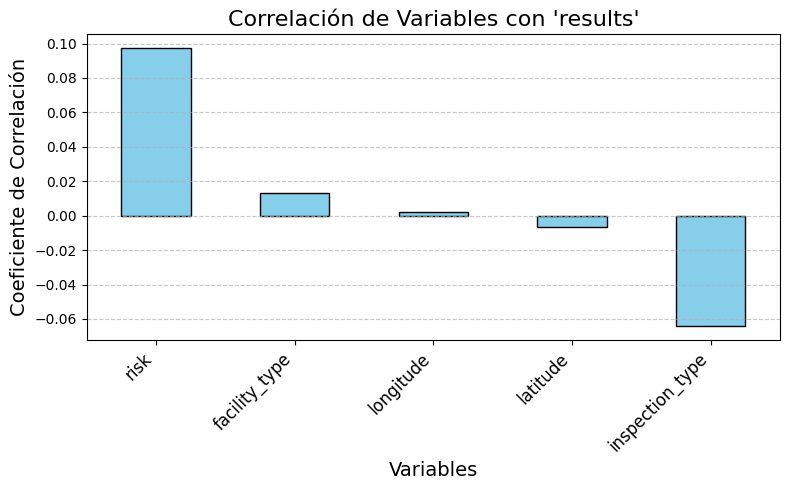

In [7]:
# Calcular la correlación de todas las columnas con 'results'
correlation_with_results = df_filtered.corr()['results'].sort_values(ascending=False)

# Mostrar las correlaciones
print("Correlación con 'results':")
print(correlation_with_results)

# Visualizar la correlación con un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
correlation_with_results.drop('results').plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Correlación de Variables con 'results'", fontsize=16)
plt.ylabel("Coeficiente de Correlación", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


La correlación de las variables con results es muy baja en general, lo que sugiere que estas características por sí solas no explican bien los resultados (Pass o Fail).
Interpretación de las Correlaciones
Variables con Correlación Positiva:
risk (0.105933):

Aunque tiene la correlación más alta con results, el valor sigue siendo bajo, indicando una relación débil.
Puede ser útil en combinación con otras características.
facility_type (0.009931):

Correlación casi nula, probablemente no es una variable predictiva significativa.
Variables con Correlación Negativa:
inspection_type (-0.083686):

Aunque la correlación es negativa, sigue siendo débil. Podría haber una ligera tendencia en ciertos tipos de inspecciones.
longitude (-0.000762) y latitude (-0.003994):

Estas variables prácticamente no tienen relación lineal con los resultados.


Dado que las correlaciones individuales son bajas, esto indica que:

Las relaciones pueden no ser lineales.

Algoritmos como Random Forest son adecuados porque capturan interacciones y no suponen relaciones lineales.
Combinaciones de variables podrían ser más útiles.

Por ejemplo, combinar risk y inspection_type para crear nuevas características.
Evaluar la importancia de características con el modelo.

Aunque las correlaciones son bajas, Random Forest puede identificar características que son importantes en combinación.

separamos los datos para entrenar

In [9]:
X = df_filtered.drop(columns=['results'])  # Todas las columnas excepto 'results'
y = df_filtered['results']  # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



Entranamos el modelo

In [10]:
# Entrenar el modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [11]:
y_pred = rf.predict(X_test)


evaluemos el modelo

In [12]:
# Evaluación del modelo
print("Matriz de Confusión:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del Modelo:")
print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")


Matriz de Confusión:
[[46010 10010]
 [16099 11952]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     56020
           1       0.54      0.43      0.48     28051

    accuracy                           0.69     84071
   macro avg       0.64      0.62      0.63     84071
weighted avg       0.68      0.69      0.68     84071


Precisión del Modelo:
68.94%


El análisis de los resultados del modelo se puede detallar de la siguiente manera:

1. Matriz de Confusión
Verdaderos Positivos (TP): 11,952 (clase 1 correctamente predicha)
Verdaderos Negativos (TN): 46,010 (clase 0 correctamente predicha)
Falsos Positivos (FP): 10,010 (clase 0 incorrectamente clasificada como clase 1)
Falsos Negativos (FN): 16,099 (clase 1 incorrectamente clasificada como clase 0)
2. Métricas Principales por Clase
Clase 0 (Negativa):
Precisión: 74% (proporción de predicciones correctas de clase 0)
Recall (Sensibilidad): 82% (capacidad del modelo para identificar correctamente los casos de clase 0)
F1-Score: 78% (promedio ponderado de precisión y recall)
Clase 1 (Positiva):
Precisión: 54%
Recall (Sensibilidad): 43%
F1-Score: 48%
3. Métricas Globales
Accuracy (Exactitud): 68.94%
Representa el porcentaje total de predicciones correctas sobre todas las instancias.
Macro Avg: Promedio simple de las métricas para ambas clases.
Precisión: 64%
Recall: 62%
F1-Score: 63%
Weighted Avg: Promedio ponderado considerando el soporte de cada clase.
Precisión: 68%
Recall: 69%
F1-Score: 68%
4. Análisis del Modelo
Fortalezas:

Buen desempeño para identificar correctamente la clase 0, como lo muestra su alto recall (82%) y F1-score (78%).
Accuracy relativamente aceptable considerando un dataset desbalanceado (56020 clase 0 vs 28051 clase 1).
Debilidades:

El modelo tiene dificultades con la clase 1:
Recall bajo (43%) indica que se pierden muchos casos positivos.
F1-score bajo (48%) refleja una combinación de baja precisión y recall para esta clase.
Posibles Mejoras:

Rebalanceo de Datos: Aplicar técnicas como sobremuestreo (SMOTE) o submuestreo para reducir el desbalance.
Ajuste del Umbral de Clasificación: Cambiar el umbral puede mejorar el recall de la clase 1 a costa de la precisión.
Ingeniería de Características: Revisar si se pueden agregar o transformar variables para mejorar el poder predictivo.
Uso de Modelos Avanzados: Probar con modelos más complejos como ensemble methods o redes neuronales.
Optimización de Hiperparámetros: Ajustar los parámetros del modelo actual para maximizar su desempeño en ambas clases.

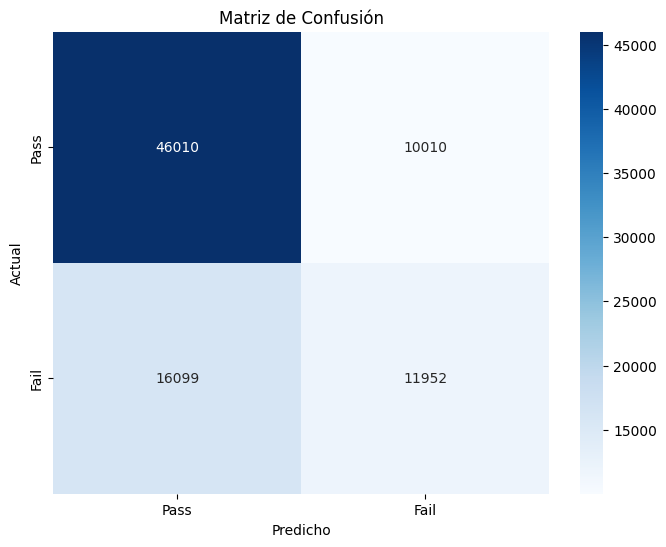

In [14]:
# Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pass", "Fail"], yticklabels=["Pass", "Fail"])
plt.title("Matriz de Confusión")
plt.ylabel("Actual")
plt.xlabel("Predicho")
plt.show()

In [15]:
# Importancia de las Características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nImportancia de las Características:")
print(feature_importances)


Importancia de las Características:
           Feature  Importance
3         latitude    0.360730
4        longitude    0.356437
2  inspection_type    0.174512
0    facility_type    0.086902
1             risk    0.021419


C:\Users\PC\AppData\Local\Temp\ipykernel_16152\3182524753.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


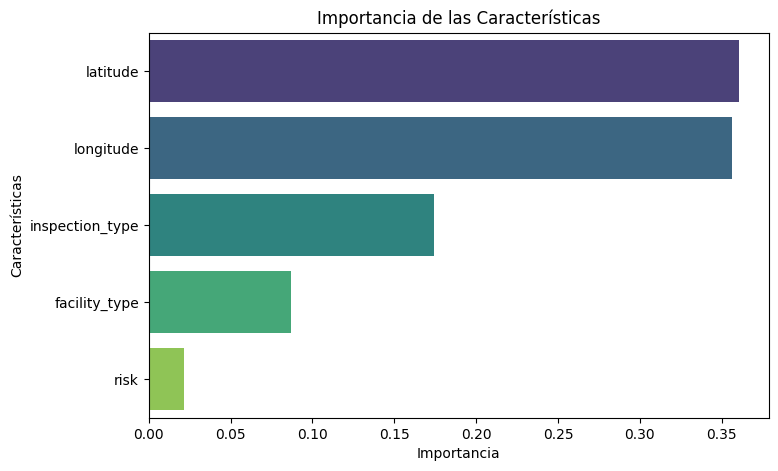

In [16]:
# Visualizar Importancia de las Características
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

Vamos a explorar mas combinaciones posibles con Hiperparametros

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Configurar Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # Número de folds para validación cruzada
    scoring='f1',  # Métrica que quieres optimizar
    verbose=2,
    n_jobs=-1  # Paralelismo para acelerar el proceso
)

# Entrenar el modelo con el Grid Search
grid_search.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     56020
           1       0.55      0.43      0.48     28051

    accuracy                           0.69     84071
   macro avg       0.64      0.63      0.63     84071
weighted avg       0.68      0.69      0.68     84071



In [18]:
# Obtener las predicciones del mejor modelo
y_pred = grid_search.best_estimator_.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[46047  9973]
 [15990 12061]]


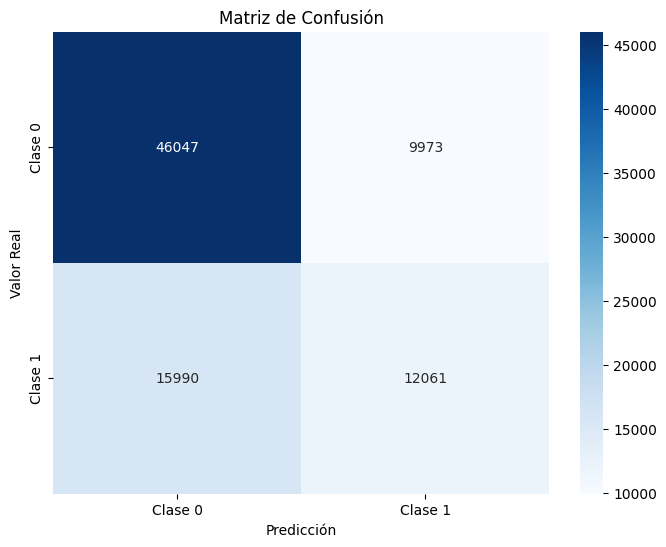

In [19]:


# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()
